In [1]:
import torch_geometric as pyg
import torch
import numpy as np
import scanpy
from collections import defaultdict
import pickle
from torch_geometric.nn.models import Node2Vec
from torch_geometric.data import HeteroData, Data
from umap import UMAP

In [2]:
from util import to_homogeneous

In [3]:
import matplotlib.pyplot as plt

In [4]:
device='cuda:0'

graph = torch.load('input/pyg_graph.torch').to(device)
node_idxs = pickle.load(open('input/nodes_by_type.pickle','rb'))
# gene_name_proteins = pickle.load(open('input/gene_name_proteins.pickle','rb'))

In [5]:
graph.metadata()[1]

[('tad', 'overlaps', 'atac_region'),
 ('tad', 'overlaps', 'gene'),
 ('gene', 'associated', 'protein'),
 ('atac_region', 'overlaps', 'gene'),
 ('protein', 'coexpressed', 'protein'),
 ('protein', 'tf_interacts', 'gene'),
 ('protein', 'is_named', 'protein_name')]

In [6]:
metapaths = [
    ('gene', 'associated', 'protein'),
    ('protein', 'coexpressed', 'protein'),
    ('protein', 'tf_interacts', 'gene'),
]

In [7]:
node_types = ['gene','protein']

In [8]:
subgraph = HeteroData()

for path in metapaths:
    subgraph[path].edge_index = graph[path].edge_index

subgraph['protein'].num_nodes = len(node_idxs['protein'])
subgraph['gene'].num_nodes = len(node_idxs['gene'])

In [9]:
subgraph = to_homogeneous(subgraph, add_node_type=True, add_edge_type=True)

In [10]:
model = Node2Vec(subgraph.edge_index, embedding_dim=128, walk_length=50,
                 context_size=25, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [11]:
def train():
    model.train()
    total_loss = 0
    for i,(pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [12]:
for epoch in range(1, 30):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 2.9331
Epoch: 02, Loss: 0.9534
Epoch: 03, Loss: 0.8810
Epoch: 04, Loss: 0.8663
Epoch: 05, Loss: 0.8613
Epoch: 06, Loss: 0.8587
Epoch: 07, Loss: 0.8572
Epoch: 08, Loss: 0.8561
Epoch: 09, Loss: 0.8559
Epoch: 10, Loss: 0.8555
Epoch: 11, Loss: 0.8555
Epoch: 12, Loss: 0.8556
Epoch: 13, Loss: 0.8556
Epoch: 14, Loss: 0.8559
Epoch: 15, Loss: 0.8559
Epoch: 16, Loss: 0.8560
Epoch: 17, Loss: 0.8561
Epoch: 18, Loss: 0.8560
Epoch: 19, Loss: 0.8561
Epoch: 20, Loss: 0.8560
Epoch: 21, Loss: 0.8559
Epoch: 22, Loss: 0.8558
Epoch: 23, Loss: 0.8559
Epoch: 24, Loss: 0.8559
Epoch: 25, Loss: 0.8559
Epoch: 26, Loss: 0.8559
Epoch: 27, Loss: 0.8559
Epoch: 28, Loss: 0.8559
Epoch: 29, Loss: 0.8559


running model
sampling
umap


/home/bglaze/miniconda3/envs/opisca/lib/python3.8/site-packages/torch_geometric/data/storage.py:244: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_type', 'edge_index', 'node_type'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


plotting


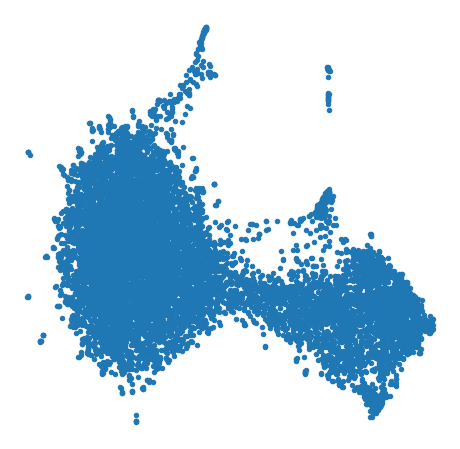

In [13]:
@torch.no_grad()
def plot_points(sample_size=10000):
    model.eval()
    print('running model')
    z = model(torch.arange(subgraph.num_nodes, device=device))
    print('sampling')
    z = z[torch.randint(low=0, high=len(z), size=(sample_size,))]
    print('umap')
    z = UMAP(n_jobs=4).fit_transform(z.cpu().numpy())
    print('plotting')
    plt.figure(figsize=(8, 8))
    plt.scatter(z[:,0], z[:,1], s=20)
    plt.axis('off')
    plt.show()

plot_points(10000)

In [48]:
embedding = model(torch.arange(subgraph.num_nodes, device=device))

In [10]:
torch.save(subgraph, 'input/node2vec_subgraph.torch')

In [77]:
torch.save(embedding, 'input/node2vec_embeddings.torch')